In [2]:
from google.colab import files

uploaded = files.upload()

Saving fear_greed_index.csv to fear_greed_index.csv
Saving historical_data.csv to historical_data.csv


In [5]:
import pandas as pd

trader_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')

# Preview the data
print("Trader Data:")
print(trader_df.head())

print("\nSentiment Data:")
print(sentiment_df.head())

# DataFrame info
print("Trader Data Info:")
trader_df.info()

print("\nSentiment Data Info:")
sentiment_df.info()

# Check for missing values
print("\nMissing in Trader Data:")
print(trader_df.isnull().sum())

print("\nMissing in Sentiment Data:")
print(sentiment_df.isnull().sum())


Trader Data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         

In [8]:
# Converting 'Timestamp IST' in trader data to datetime
trader_df['timestamp_dt'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Also extracting just the date part (for merging later)
trader_df['date'] = trader_df['timestamp_dt'].dt.date

# Converting 'date' in sentiment data to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
print("Trader data range:", trader_df['date'].min(), "to", trader_df['date'].max())
print("Sentiment data range:", sentiment_df['date'].min(), "to", sentiment_df['date'].max())

# Merge on the 'date' column
merged_df = pd.merge(trader_df, sentiment_df[['date', 'classification']], on='date', how='left')

# Checking if any trades are missing sentiment classification
print("Missing sentiment entries after merge:", merged_df['classification'].isnull().sum())

# Preview the merged dataset
merged_df[['timestamp_dt', 'Closed PnL', 'classification']].head()


Trader data range: 2023-05-01 to 2025-05-01
Sentiment data range: 2018-02-01 to 2025-05-02
Missing sentiment entries after merge: 6


,timestamp_dt,Closed PnL,classification
0,2024-12-02 22:50:00,0.0,Extreme Greed
1,2024-12-02 22:50:00,0.0,Extreme Greed
2,2024-12-02 22:50:00,0.0,Extreme Greed
3,2024-12-02 22:50:00,0.0,Extreme Greed
4,2024-12-02 22:50:00,0.0,Extreme Greed


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['timestamp_dt']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'timestamp_dt'}, axis=1)
              .sort_values('timestamp_dt', ascending=True))
  xs = counted['timestamp_dt']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('timestamp_dt', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp_dt')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Closed PnL']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Closed PnL'}, axis=1)
              .sort_values('Closed PnL', ascending=True))
  xs = counted['Closed PnL']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Closed PnL', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Closed PnL')
_ = plt.ylabel('count()')

In [10]:
# Binary label: was this trade profitable?
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0

# Example: classify leverage usage (if leverage column exists)
# merged_df['leverage_category'] = pd.cut(merged_df['Leverage'], bins=[0, 2, 5, 10, 50, 100], labels=['Low', 'Moderate', 'High', 'Very High', 'Extreme'])

merged_df['pnl_per_usd'] = merged_df['Closed PnL'] / merged_df['Size USD']

def simplify_sentiment(x):
    if pd.isna(x):
        return 'Unknown'
    elif 'Fear' in x:
        return 'Fear'
    elif 'Greed' in x:
        return 'Greed'
    else:
        return x

merged_df['sentiment_simple'] = merged_df['classification'].apply(simplify_sentiment)


# Group by sentiment and calculate average metrics
sentiment_group = merged_df.groupby('sentiment_simple').agg({
    'Closed PnL': ['mean', 'sum'],
    'is_profitable': 'mean',
    'Size USD': 'mean',
    'Fee': 'mean'
}).reset_index()

sentiment_group.columns = ['Sentiment', 'Avg PnL', 'Total PnL', 'Win Rate', 'Avg Trade Size', 'Avg Fee']
sentiment_group


,Sentiment,Avg PnL,Total PnL,Win Rate,Avg Trade Size,Avg Fee
0,Fear,49.212077,4.096266e+06,0.407871,7182.011019,1.397763
1,Greed,53.882281,4.865301e+06,0.420311,4574.424490,0.998166
2,Neutral,34.307718,1.292921e+06,0.396991,4782.732661,1.044798
3,Unknown,7078.665688,4.247199e+04,1.000000,14778.143333,1.418701


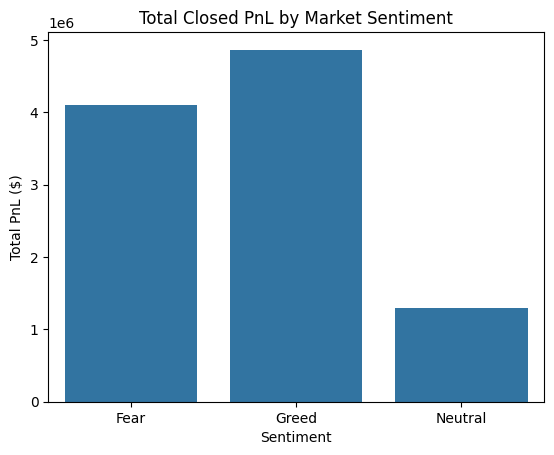

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Total PnL per sentiment
sns.barplot(data=sentiment_group[sentiment_group['Sentiment'] != 'Unknown'], x='Sentiment', y='Total PnL')
plt.title('Total Closed PnL by Market Sentiment')
plt.ylabel('Total PnL ($)')
plt.show()


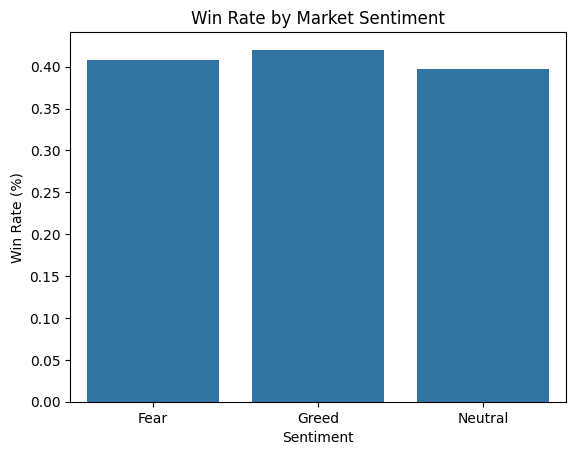

In [14]:
sns.barplot(data=sentiment_group[sentiment_group['Sentiment'] != 'Unknown'], x='Sentiment', y='Win Rate')
plt.title('Win Rate by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.show()


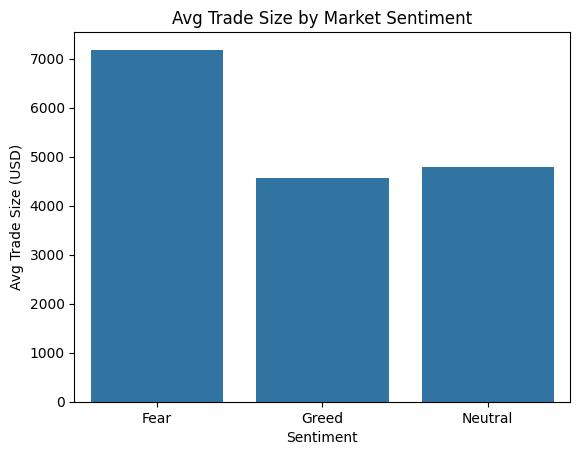

In [15]:
sns.barplot(data=sentiment_group[sentiment_group['Sentiment'] != 'Unknown'], x='Sentiment', y='Avg Trade Size')
plt.title('Avg Trade Size by Market Sentiment')
plt.ylabel('Avg Trade Size (USD)')
plt.show()


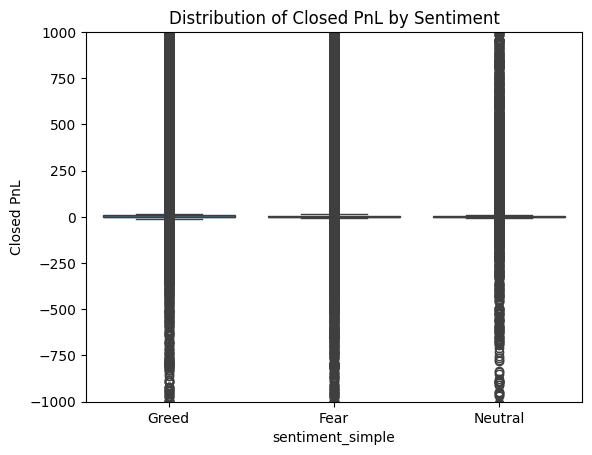

In [16]:
# Boxplot of Closed PnL for different sentiments
sns.boxplot(data=merged_df[merged_df['sentiment_simple'] != 'Unknown'],
            x='sentiment_simple', y='Closed PnL')
plt.title('Distribution of Closed PnL by Sentiment')
plt.ylim(-1000, 1000)  # Set y-limits to exclude extreme outliers
plt.show()
